In [1]:
!pip install torch torchvision scipy pillow numpy
!pip install diffusers==0.11.1
!pip install transformers ftfy accelerate
!pip install pandas

In [2]:
import torch
import scipy.io
import numpy as np
import torchvision
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from diffusers import StableDiffusionPipeline
from torchvision import transforms
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast

In [3]:
mat = scipy.io.loadmat("fMRI_data.mat")
subjects = mat['subject'][0]
scans = mat['data']
img_shpae = mat['imgShape']
file_names = scipy.io.loadmat("stimuli.mat")['stimuli']

active_scans = []
images = []
img_names = []

active_scans_test = []
images_test = []
img_names_test = []


directory = 'encoded_stim'
for i in range(len(file_names)):
    name = file_names[i].strip()
    if name != '':
        if subjects[i] != 6:
            active_scans.append(torch.from_numpy(scans[i]))
            f_name = os.path.join(directory, os.path.splitext(name)[0]) + ".pt"
            images.append(torch.flatten(torch.load(f_name)))
            img_names.append(name)
        else:
            active_scans_test.append(torch.from_numpy(scans[i]))
            f_name = os.path.join(directory, os.path.splitext(name)[0]) + ".pt"
            images_test.append(torch.flatten(torch.load(f_name)))
            img_names_test.append(name)


active_scans = torch.vstack(active_scans)
images = torch.vstack(images)
img_names = np.array(img_names)

active_scans_test = torch.vstack(active_scans_test)
images_test = torch.vstack(images_test)
img_names_test = np.array(img_names_test)

In [4]:
active_scans.shape

torch.Size([4359, 2294])

In [5]:
images.shape

torch.Size([4359, 16384])

In [4]:
class ContrastiveLossDataset(Dataset):
    def __init__(self, scans, images, img_names):
        self.scans = scans
        self.images = images
        self.img_names = img_names

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        # figure out how to add noise
        return self.scans[idx], self.images[idx], self.img_names[idx]

In [10]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        self.image_model = torch.nn.Sequential(
            torch.nn.Linear(16384, 8192),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(8192),
            torch.nn.Linear(8192, 4096),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(4096),
            torch.nn.Linear(4096, 1024),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(1024),
            torch.nn.Linear(1024, 256)
        )
        self.fMRI_model = torch.nn.Sequential(
            torch.nn.Linear(2294, 1024),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(1024),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(512),
            torch.nn.Linear(512, 256)
        )

    def forward(self, fMRI, image_encoding):
        x = self.image_model(image_encoding)
        y = self.fMRI_model(fMRI)
        return x, y
        

In [7]:
test_set = ContrastiveLossDataset(active_scans, images, img_names)
loader = DataLoader(test_set, batch_size=4, shuffle=True)

In [8]:
scan_batch, image_batch, img_names_batch = next(iter(loader))

In [9]:
train_set = ContrastiveLossDataset(active_scans, images, img_names)
test_set = ContrastiveLossDataset(active_scans_test, images_test, img_names_test)

train_loader = DataLoader(train_set, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_set, batch_size = 16, shuffle=True)

model = ContrastiveLoss().to('cuda')
epochs = 2

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

cos = torch.nn.CosineSimilarity(dim=-1)
softmax = torch.nn.Softmax(dim=-1)

for i in tqdm(range(epochs)):
    for i, (data) in enumerate(train_loader):
        scan_batch, image_batch, img_names_batch = data
        
        scan_batch = scan_batch.to('cuda')
        image_batch = image_batch.to('cuda')
        
        img_names_batch = np.array(img_names_batch)
        img_names_batch_t = img_names_batch.reshape(-1,1)
        
        mask = (img_names_batch == img_names_batch_t).astype(np.float32)
        targets = torch.Tensor(mask/np.sum(mask, -1)).to('cuda')
        
        optimizer.zero_grad()
        
        x, y = model(scan_batch, image_batch)
        
        sim_scores = cos(x[:, None], y[None, :])
        sim_probs = softmax(sim_scores)
        
        loss = loss_fn(sim_probs, targets)
        
        loss.backward()
        optimizer.step()

  0%|          | 0/2 [00:00<?, ?it/s]

In [22]:
class Diffusion():
    def __init__(self, contrastive_classifier):
        self.contrastive_classifier = contrastive_classifier
        self.unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
        # unet model predicts epsilon
        self.text_embeddings = self.get_blank_text_condition()
        self.scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
        self.scheduler.set_timesteps(1000)

        self.vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
        

    def get_blank_text_condition(self):
        tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
        text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
        prompt = [""]
        text_input = tokenizer(
            prompt, 
            padding="max_length", 
            max_length=tokenizer.model_max_length, 
            truncation=True, 
            return_tensors="pt"
        )
        with torch.no_grad():
            text_embeddings = text_encoder(text_input.input_ids)[0]
        return text_embeddings

    def run(self):
        self.unet.to('cuda')
        height = 512                        # default height of Stable Diffusion
        width = 512
        latents = torch.randn(
            (1, self.unet.in_channels, height // 8, width // 8),
        )
        latents = latents.to('cuda') * self.scheduler.init_noise_sigma.to('cuda')
        for t in tqdm(self.scheduler.timesteps):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = self.scheduler.scale_model_input(latents, t)
        
            # predict the noise residual
            with torch.no_grad():
                noise_pred = self.unet(latent_model_input.to('cuda'), t.to('cuda'), encoder_hidden_states=self.text_embeddings.to('cuda')).sample
        
        
            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents).prev_sample
        self.unet.to('cpu')
        self.vae.to('cuda')
        latents = 1 / 0.18215 * latents

        with torch.no_grad():
            image = self.vae.decode(latents).sample
        
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        images = (image * 255).round().astype("uint8")
        pil_images = [Image.fromarray(image) for image in images]
        return pil_images[0]
        
        
        

In [11]:
model = ContrastiveLoss()

In [23]:
diffuser = Diffusion(model)

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/1000 [00:00<?, ?it/s]

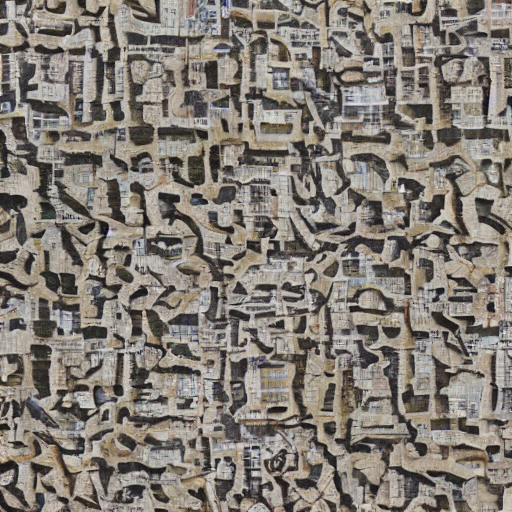

In [25]:
diffuser.run()